In [8]:
import pandas as pd
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# Cargar datos
df = pd.read_csv("dstn_5.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# Pivotear: filas = productos, columnas = fechas
df_pivot = df.pivot_table(index='product_id', columns='periodo', values='tn', aggfunc='sum').fillna(0)

# Asegurar formato [n_series, n_timestamps, 1]
X = df_pivot.values[:, :, np.newaxis]

# Normalizar (opcional pero recomendado para DTW)
scaler = TimeSeriesScalerMeanVariance()
X_scaled = scaler.fit_transform(X)

# Clustering con DTW
n_clusters = 5  # podés cambiarlo según el caso
km_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)
labels = km_dtw.fit_predict(X_scaled)

# Guardar resultado
df_clusters = pd.DataFrame({
    'product_id': df_pivot.index,
    'cluster_dtw': labels
})
df_clusters.to_csv("dtw_clusters5.csv", index=False)
print("✅ Archivo dtw_clusters5.csv generado correctamente.")


c:\Users\waldo\miniconda3\envs\dtw_regresion\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\waldo\miniconda3\envs\dtw_regresion\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\waldo\miniconda3\envs\dtw_regresion\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\waldo\miniconda3\envs\dtw_regresion\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Archivo dtw_clusters5.csv generado correctamente.


In [9]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# 1. Cargar datasets
df = pd.read_csv("dstn_5.csv")
df['periodo'] = pd.to_datetime(df['periodo'])
df_clusters = pd.read_csv("dtw_clusters5.csv")  # columnas: product_id, cluster_dtw

# 2. Agrupar por producto y mes
df_prod = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Agregar cluster
df_prod = df_prod.merge(df_clusters, on='product_id', how='left')

# 4. Promedio histórico de febreros (2017–2019)
feb_hist = df_prod[
    (df_prod['periodo'].dt.month == 2) & (df_prod['periodo'].dt.year < 2020)
].groupby('product_id')['tn'].mean().reset_index()
feb_hist.rename(columns={'tn': 'febrero_hist'}, inplace=True)

# 5. Media móvil 12 meses
df_prod = df_prod.sort_values(['product_id', 'periodo'])
df_prod['media_movil_12m'] = (
    df_prod.groupby('product_id')['tn']
    .transform(lambda x: x.rolling(window=12, min_periods=1).mean())
)

# 6. Crear lags
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

df_lags = crear_lags(df_prod)
df_lags['mes'] = df_lags['periodo'].dt.month

# 7. Features derivados
df_lags['var_lag1_lag2'] = df_lags['lag_1'] / df_lags['lag_2']
df_lags['delta_lag1_lag2'] = df_lags['lag_1'] - df_lags['lag_2']
df_lags['delta_rel_lag1_lag2'] = df_lags['delta_lag1_lag2'] / df_lags['lag_2']
df_lags['delta_ma12_lag1'] = df_lags['lag_1'] - df_lags['media_movil_12m']
df_lags.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# 8. Preparar entrenamiento
df_train = df_lags.dropna()

features = [
    'lag_1', 'lag_2', 'lag_3', 'mes',
    'media_movil_12m', 'var_lag1_lag2',
    'delta_lag1_lag2', 'delta_rel_lag1_lag2', 'delta_ma12_lag1',
    'cluster_dtw'
]
target = 'tn'

train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features].copy()
y_train = train_data[target]
X_val = val_data[features].copy()
y_val = val_data[target]

# Conversión a float32 explícita
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

# 9. Entrenar modelo
mejores_params = {
     'n_estimators': 261,
    'learning_rate': 0.14224983178543588,
    'max_depth': 10,
    'num_leaves': 23,
    'subsample': 0.8093211391867557,
    'colsample_bytree': 0.9231869885459679,
    'random_state': 42,
    'min_data_in_leaf': 29,
    'reg_alpha': 2.699481657936518,
    'reg_lambda': 2.8632226095063658,
    'linear_tree': True
}
modelo = lgb.LGBMRegressor(**mejores_params)
modelo.fit(X_train, y_train)

# 10. Validación
y_pred_val = modelo.predict(X_val)
print("📊 MAE en diciembre 2019:", mean_absolute_error(y_val, y_pred_val))

# 11. Preparar predicción febrero 2020
feb_df = pd.DataFrame()
feb_df['product_id'] = df_prod['product_id'].unique()
feb_df['periodo'] = pd.to_datetime('2020-02-01')
feb_df['mes'] = 2

lag1_df = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'media_movil_12m']].rename(columns={'media_movil_12m': 'lag_1'})
lag2 = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'tn']].rename(columns={'tn': 'lag_2'})
lag3 = df_prod[df_prod['periodo'] == '2019-11-01'][['product_id', 'tn']].rename(columns={'tn': 'lag_3'})
media_mov = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'media_movil_12m']]
clusters = df_clusters.copy()

feb_df = feb_df.merge(lag1_df, on='product_id')
feb_df = feb_df.merge(lag2, on='product_id')
feb_df = feb_df.merge(lag3, on='product_id')
feb_df = feb_df.merge(media_mov, on='product_id')
feb_df = feb_df.merge(clusters, on='product_id')

feb_df['var_lag1_lag2'] = feb_df['lag_1'] / feb_df['lag_2']
feb_df['delta_lag1_lag2'] = feb_df['lag_1'] - feb_df['lag_2']
feb_df['delta_rel_lag1_lag2'] = feb_df['delta_lag1_lag2'] / feb_df['lag_2']
feb_df['delta_ma12_lag1'] = feb_df['lag_1'] - feb_df['media_movil_12m']
feb_df = feb_df.merge(feb_hist, on='product_id', how='left')
feb_df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# Conversión a float32 para predicción
feb_df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
feb_df.fillna(0, inplace=True)  # ⬅️ esta línea te faltaba
X_feb = feb_df[features].astype('float32')


# 12. Predicción
feb_df['tn_predicho'] = modelo.predict(X_feb)
feb_df['tn_predicho_ajustada'] = 1 * feb_df['tn_predicho'] + 0 * feb_df['febrero_hist']

# 13. Exportar
resultado = feb_df[['product_id', 'tn_predicho_ajustada']].rename(columns={'tn_predicho_ajustada': 'tn_predicho'})
resultado.to_csv("prediccion_feb2020_dstn5.csv", index=False)
print("✅ Predicción febrero 2020 guardada en prediccion_feb2020_dstn5.csv")


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2058
[LightGBM] [Info] Number of data points in the train set: 5085, number of used features: 10
[LightGBM] [Info] Start training from score 19.595579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

C:\Users\waldo\AppData\Local\Temp\ipykernel_20304\4003943062.py:117: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feb_df.fillna(0, inplace=True)  # ⬅️ esta línea te faltaba


In [10]:
import pandas as pd

# 1. Cargar predicción de febrero 2020
df_pred = pd.read_csv("prediccion_feb2020_dstn5.csv")  # archivo generado por el modelo
df_pred['periodo'] = pd.to_datetime("2020-02-01")
df_pred.rename(columns={'tn_predicho': 'tn'}, inplace=True)

# 2. Cargar dataset original
df_real = pd.read_csv("dstn_5.csv")
df_real["periodo"] = pd.to_datetime(df_real["periodo"])

# 3. Agrupar por período y sumar toneladas reales
tn_reales = df_real.groupby(["periodo"])["tn"].sum().reset_index()

# 4. Sumar toneladas predichas para febrero 2020
tn_feb2020 = df_pred.groupby("periodo")["tn"].sum().reset_index()

# 5. Unir y ordenar
comparacion = pd.concat([tn_reales, tn_feb2020], ignore_index=True)
comparacion = comparacion.sort_values("periodo").reset_index(drop=True)

# 6. Mostrar resultado
print("📊 Total de toneladas por período (incluye predicción febrero 2020):")
print(comparacion.tail(36))  # los últimos 12 períodos


📊 Total de toneladas por período (incluye predicción febrero 2020):
      periodo           tn
1  2017-02-01  2623.928010
2  2017-03-01  3785.942260
3  2017-04-01  3087.452170
4  2017-05-01  3816.745320
5  2017-06-01  3414.566840
6  2017-07-01  2752.890060
7  2017-08-01  3311.019800
8  2017-09-01  3872.691070
9  2017-10-01  4152.036120
10 2017-11-01  3680.597200
11 2017-12-01  3212.721670
12 2018-01-01  2385.911280
13 2018-02-01  2832.758060
14 2018-03-01  4122.745050
15 2018-04-01  3057.314820
16 2018-05-01  3336.068500
17 2018-06-01  3120.921680
18 2018-07-01  2893.138240
19 2018-08-01  3375.198120
20 2018-09-01  2876.738360
21 2018-10-01  3385.598280
22 2018-11-01  2830.994860
23 2018-12-01  2479.692050
24 2019-01-01  2822.575280
25 2019-02-01  2708.162230
26 2019-03-01  3302.827380
27 2019-04-01  3117.580780
28 2019-05-01  3171.450660
29 2019-06-01  2661.685910
30 2019-07-01  3065.455570
31 2019-08-01  2419.032550
32 2019-09-01  3085.648900
33 2019-10-01  3207.739640
34 2019-11-01 


📌 Importancia de variables:
               feature  importancia
2                lag_3          859
8      delta_ma12_lag1          779
4      media_movil_12m          774
1                lag_2          641
6      delta_lag1_lag2          624
0                lag_1          614
5        var_lag1_lag2          504
3                  mes          409
9          cluster_dtw          235
7  delta_rel_lag1_lag2           76


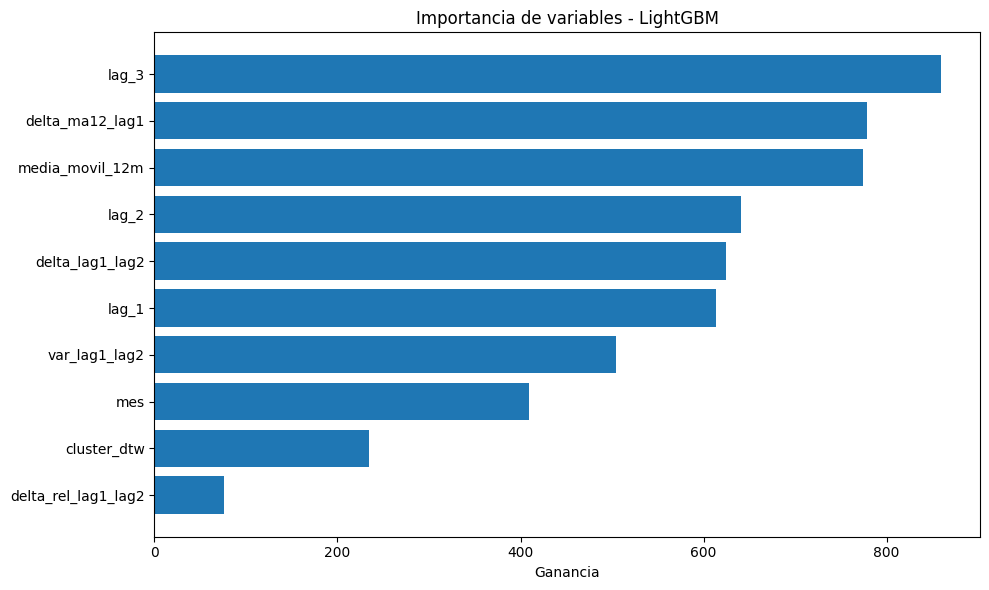

In [11]:
# 🔍 Importancia de variables
import matplotlib.pyplot as plt

# Crear DataFrame con la importancia
importancias = pd.DataFrame({
    'feature': modelo.feature_name_,
    'importancia': modelo.feature_importances_
}).sort_values(by='importancia', ascending=False).head(10)

# Mostrar en consola
print("\n📌 Importancia de variables:")
print(importancias)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(importancias['feature'], importancias['importancia'])
plt.gca().invert_yaxis()
plt.title("Importancia de variables - LightGBM")
plt.xlabel("Ganancia")
plt.tight_layout()
plt.show()


In [12]:
# 14. Comparación contra histórico total de febreros anteriores
df_feb = df[
    (df['periodo'].dt.month == 2) &
    (df['periodo'].dt.year.isin([2017, 2018, 2019]))
]

total_feb_2017 = df_feb[df_feb['periodo'].dt.year == 2017]['tn'].sum()
total_feb_2018 = df_feb[df_feb['periodo'].dt.year == 2018]['tn'].sum()
total_feb_2019 = df_feb[df_feb['periodo'].dt.year == 2019]['tn'].sum()

promedio_total_feb = (total_feb_2017 + total_feb_2018 + total_feb_2019) / 3

# 15. Comparación con predicción
comparacion = feb_df[['product_id', 'tn_predicho', 'tn_predicho_ajustada']].copy()

total_modelo = comparacion['tn_predicho'].sum()
total_ajustada = comparacion['tn_predicho_ajustada'].sum()

print("\n🔎 Comparación de totales:")
print(f"📉 Predicción solo modelo...........: {total_modelo:,.2f} tn")
print(f"⚖️  Predicción ajustada (1/0)......: {total_ajustada:,.2f} tn")
print(f"📜 Promedio histórico total febreros (2017–2019): {promedio_total_feb:,.2f} tn")



🔎 Comparación de totales:
📉 Predicción solo modelo...........: 3,271.54 tn
⚖️  Predicción ajustada (1/0)......: 3,271.54 tn
📜 Promedio histórico total febreros (2017–2019): 2,721.62 tn


📈 R² en diciembre 2019: 0.6037
📉 Sesgo promedio: -2.8575


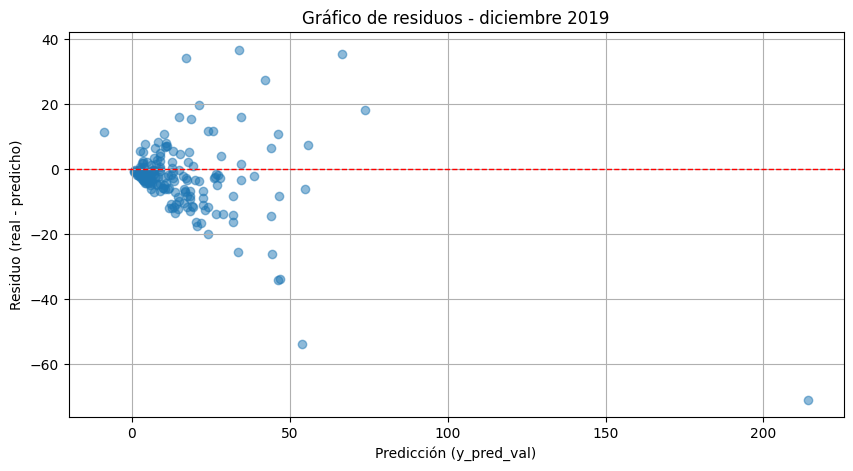

In [13]:
#DESDE ACÁ 1

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Calcular residuos
residuos = y_val - y_pred_val

# Calcular R² y sesgo promedio
r2 = r2_score(y_val, y_pred_val)
sesgo_promedio = np.mean(residuos)

# Mostrar métricas
print(f"📈 R² en diciembre 2019: {r2:.4f}")
print(f"📉 Sesgo promedio: {sesgo_promedio:.4f}")

# Gráfico de residuos
plt.figure(figsize=(10, 5))
plt.scatter(y_pred_val, residuos, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicción (y_pred_val)')
plt.ylabel('Residuo (real - predicho)')
plt.title('Gráfico de residuos - diciembre 2019')
plt.grid(True)
plt.show()


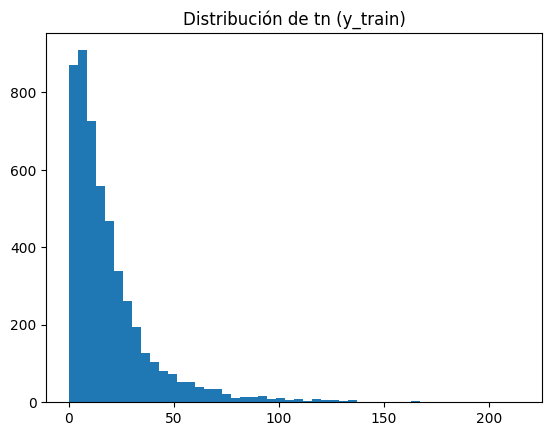

In [14]:
#DESDE ACÁ 2
import matplotlib.pyplot as plt
plt.hist(y_train, bins=50)
plt.title("Distribución de tn (y_train)")
plt.show()


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2058
[LightGBM] [Info] Number of data points in the train set: 5085, number of used features: 10
[LightGBM] [Info] Start training from score 2.590968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

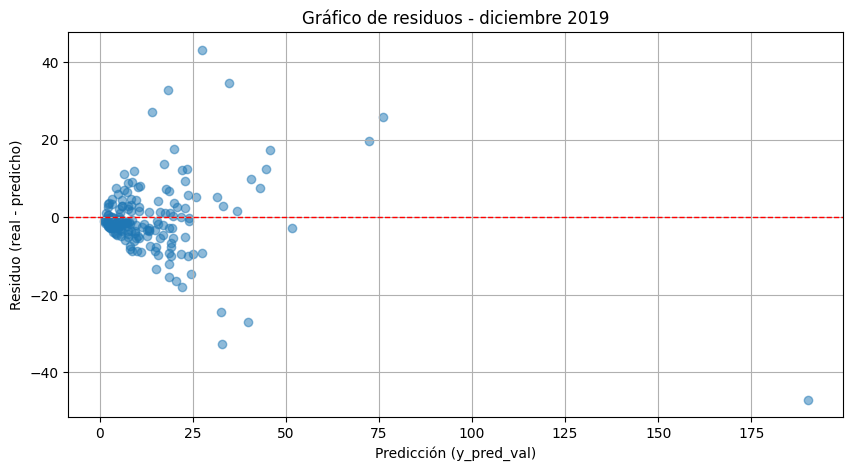

[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
✅ Predicción febrero 2020 guardada en prediccion_feb2020_dstn5_1.csv


C:\Users\waldo\AppData\Local\Temp\ipykernel_20304\4090157547.py:140: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feb_df.fillna(0, inplace=True)
C:\Users\waldo\AppData\Local\Temp\ipykernel_20304\4090157547.py:146: RuntimeWarning: overflow encountered in expm1
  pred_original = np.expm1(pred_log)


In [27]:
#DESDE ACÁ 3
import pandas as pd
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Cargar datasets
df = pd.read_csv("dstn_5.csv")
df['periodo'] = pd.to_datetime(df['periodo'])
df_clusters = pd.read_csv("dtw_clusters5.csv")  # columnas: product_id, cluster_dtw

# 2. Agrupar por producto y mes
df_prod = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Agregar cluster
df_prod = df_prod.merge(df_clusters, on='product_id', how='left')

# 4. Promedio histórico de febreros (2017–2019)
feb_hist = df_prod[
    (df_prod['periodo'].dt.month == 2) & (df_prod['periodo'].dt.year < 2020)
].groupby('product_id')['tn'].mean().reset_index()
feb_hist.rename(columns={'tn': 'febrero_hist'}, inplace=True)

# 5. Media móvil 12 meses
df_prod = df_prod.sort_values(['product_id', 'periodo'])
df_prod['media_movil_12m'] = (
    df_prod.groupby('product_id')['tn']
    .transform(lambda x: x.rolling(window=12, min_periods=1).mean())
)

# 6. Crear lags
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

df_lags = crear_lags(df_prod)
df_lags['mes'] = df_lags['periodo'].dt.month

# 7. Features derivados
df_lags['var_lag1_lag2'] = df_lags['lag_1'] / df_lags['lag_2']
df_lags['delta_lag1_lag2'] = df_lags['lag_1'] - df_lags['lag_2']
df_lags['delta_rel_lag1_lag2'] = df_lags['delta_lag1_lag2'] / df_lags['lag_2']
df_lags['delta_ma12_lag1'] = df_lags['lag_1'] - df_lags['media_movil_12m']
df_lags.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# 8. Preparar entrenamiento
df_train = df_lags.dropna()

features = [
    'lag_1', 'lag_2', 'lag_3', 'mes',
    'media_movil_12m', 'var_lag1_lag2',
    'delta_lag1_lag2', 'delta_rel_lag1_lag2', 'delta_ma12_lag1',
    'cluster_dtw'
]
target = 'tn'

train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features].copy()
y_train = train_data[target]
X_val = val_data[features].copy()
y_val = val_data[target]

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

# 🔄 Log-transform del target
y_train_log = np.log1p(y_train)

# 9. Entrenar modelo
mejores_params = {
    'n_estimators': 261,
    'learning_rate': 0.14224983178543588,
    'max_depth': 10,
    'num_leaves': 23,
    'subsample': 0.8093211391867557,
    'colsample_bytree': 0.9231869885459679,
    'random_state': 42,
    'min_data_in_leaf': 29,
    'reg_alpha': 2.699481657936518,
    'reg_lambda': 2.8632226095063658,
    'linear_tree': True
}
modelo = lgb.LGBMRegressor(**mejores_params)
modelo.fit(X_train, y_train_log)

# 🔄 Predicción log → escala original
y_pred_val_log = modelo.predict(X_val)
y_pred_val = np.expm1(y_pred_val_log)

# ⏱️ Métricas
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)
residuos = y_val - y_pred_val
sesgo = np.mean(residuos)

print(f"📊 MAE en diciembre 2019: {mae:.2f}")
print(f"📈 R² en diciembre 2019: {r2:.4f}")
print(f"📉 Sesgo promedio: {sesgo:.4f}")

# 📉 Gráfico de residuos
plt.figure(figsize=(10, 5))
plt.scatter(y_pred_val, residuos, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicción (y_pred_val)')
plt.ylabel('Residuo (real - predicho)')
plt.title('Gráfico de residuos - diciembre 2019')
plt.grid(True)
plt.savefig("grafico_residuos_diciembre2019.png", dpi=300)
plt.show()

# 11. Predicción febrero 2020
feb_df = pd.DataFrame()
feb_df['product_id'] = df_prod['product_id'].unique()
feb_df['periodo'] = pd.to_datetime('2020-02-01')
feb_df['mes'] = 2

lag1_df = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'media_movil_12m']].rename(columns={'media_movil_12m': 'lag_1'})
lag2 = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'tn']].rename(columns={'tn': 'lag_2'})
lag3 = df_prod[df_prod['periodo'] == '2019-11-01'][['product_id', 'tn']].rename(columns={'tn': 'lag_3'})
media_mov = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'media_movil_12m']]
clusters = df_clusters.copy()

feb_df = feb_df.merge(lag1_df, on='product_id')
feb_df = feb_df.merge(lag2, on='product_id')
feb_df = feb_df.merge(lag3, on='product_id')
feb_df = feb_df.merge(media_mov, on='product_id')
feb_df = feb_df.merge(clusters, on='product_id')

feb_df['var_lag1_lag2'] = feb_df['lag_1'] / feb_df['lag_2']
feb_df['delta_lag1_lag2'] = feb_df['lag_1'] - feb_df['lag_2']
feb_df['delta_rel_lag1_lag2'] = feb_df['delta_lag1_lag2'] / feb_df['lag_2']
feb_df['delta_ma12_lag1'] = feb_df['lag_1'] - feb_df['media_movil_12m']
feb_df = feb_df.merge(feb_hist, on='product_id', how='left')
feb_df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
feb_df.fillna(0, inplace=True)

X_feb = feb_df[features].astype('float32')

# 🔄 Predicción log → original (con protección contra inf)
pred_log = modelo.predict(X_feb)
pred_original = np.expm1(pred_log)
pred_original = np.where(np.isfinite(pred_original), pred_original, 0)

feb_df['tn_predicho'] = pred_original
feb_df['tn_predicho_ajustada'] = feb_df['tn_predicho']


# 13. Exportar
resultado = feb_df[['product_id', 'tn_predicho_ajustada']].rename(columns={'tn_predicho_ajustada': 'tn_predicho'})
resultado.to_csv("prediccion_feb2020_dstn5_1.csv", index=False)
print("✅ Predicción febrero 2020 guardada en prediccion_feb2020_dstn5_1.csv")


In [28]:
#DESDE ACÁ 4
import pandas as pd

# 1. Cargar predicción de febrero 2020
df_pred = pd.read_csv("prediccion_feb2020_dstn5_1.csv")  # archivo generado por el modelo
df_pred['periodo'] = pd.to_datetime("2020-02-01")
df_pred.rename(columns={'tn_predicho': 'tn'}, inplace=True)

# 2. Cargar dataset original
df_real = pd.read_csv("dstn_5.csv")
df_real["periodo"] = pd.to_datetime(df_real["periodo"])

# 3. Agrupar por período y sumar toneladas reales
tn_reales = df_real.groupby(["periodo"])["tn"].sum().reset_index()

# 4. Sumar toneladas predichas para febrero 2020
tn_feb2020 = df_pred.groupby("periodo")["tn"].sum().reset_index()

# 5. Unir y ordenar
comparacion = pd.concat([tn_reales, tn_feb2020], ignore_index=True)
comparacion = comparacion.sort_values("periodo").reset_index(drop=True)

# 6. Mostrar resultado
print("📊 Total de toneladas por período (incluye predicción febrero 2020):")
print(comparacion.tail(36))  # los últimos 12 períodos


📊 Total de toneladas por período (incluye predicción febrero 2020):
      periodo          tn
1  2017-02-01  2623.92801
2  2017-03-01  3785.94226
3  2017-04-01  3087.45217
4  2017-05-01  3816.74532
5  2017-06-01  3414.56684
6  2017-07-01  2752.89006
7  2017-08-01  3311.01980
8  2017-09-01  3872.69107
9  2017-10-01  4152.03612
10 2017-11-01  3680.59720
11 2017-12-01  3212.72167
12 2018-01-01  2385.91128
13 2018-02-01  2832.75806
14 2018-03-01  4122.74505
15 2018-04-01  3057.31482
16 2018-05-01  3336.06850
17 2018-06-01  3120.92168
18 2018-07-01  2893.13824
19 2018-08-01  3375.19812
20 2018-09-01  2876.73836
21 2018-10-01  3385.59828
22 2018-11-01  2830.99486
23 2018-12-01  2479.69205
24 2019-01-01  2822.57528
25 2019-02-01  2708.16223
26 2019-03-01  3302.82738
27 2019-04-01  3117.58078
28 2019-05-01  3171.45066
29 2019-06-01  2661.68591
30 2019-07-01  3065.45557
31 2019-08-01  2419.03255
32 2019-09-01  3085.64890
33 2019-10-01  3207.73964
34 2019-11-01  3215.25430
35 2019-12-01  2381.40

📊 Error por decil histórico:
   decil_hist  tn_predicho  febrero_hist  error_abs  error_relativo
0           1     4.202074      1.584565   3.219192   713854.755395
1           2     4.003330      3.327505   2.765838        0.900862
2           3     5.000534      5.079970   3.395894        0.686119
3           4     8.548811      7.343055   4.192271        0.549977
4           5     7.829841      9.427448   3.225826        0.350726
5           6    10.693115     12.468018   4.661200        0.371211
6           7    13.457653     15.385453   4.936995        0.321605
7           8    20.130586     18.548929   8.636774        0.484917
8           9    17.985914     27.606204  10.217953        0.351245
9          10    35.849639     59.323917  23.741026        0.417124

📊 Error por cluster DTW:
   cluster_dtw  tn_predicho  febrero_hist  error_abs  error_relativo
0            0    13.238090     14.848753   3.846720        0.393297
1            1    11.406051     17.539977   7.624156       

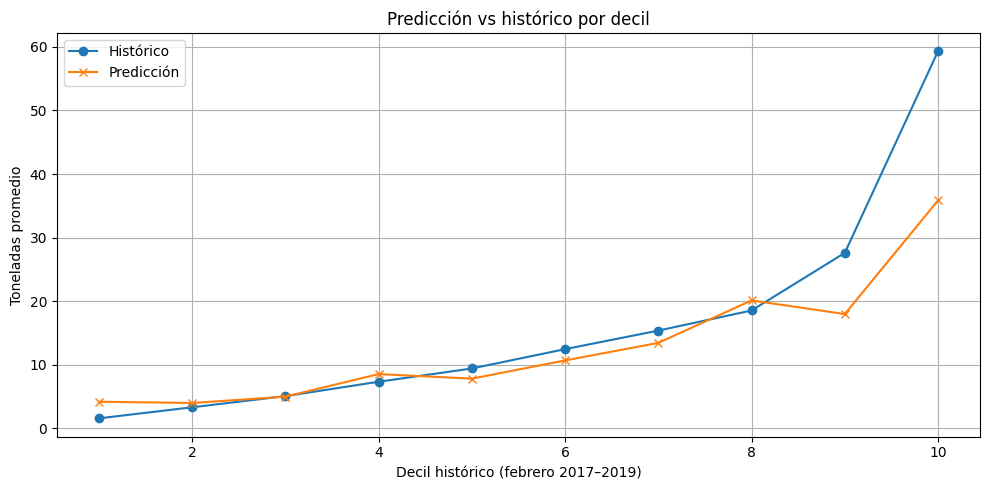

In [29]:
#DESDE ACÁ 5

# ===============================
# ANÁLISIS POR DECIL Y CLUSTER DTW
# ===============================

import matplotlib.pyplot as plt

# 1. Deciles históricos (1 = bajo, 10 = alto)
feb_df['decil_hist'] = pd.qcut(feb_df['febrero_hist'], q=10, labels=False, duplicates='drop') + 1

# 2. Métricas por decil
decil_stats = feb_df.groupby('decil_hist').agg(
    tn_predicho=('tn_predicho_ajustada', 'mean'),
    febrero_hist=('febrero_hist', 'mean'),
    error_abs=('tn_predicho', lambda x: np.mean(np.abs(x - feb_df.loc[x.index, 'febrero_hist']))),
    error_relativo=('tn_predicho', lambda x: np.mean(np.abs(x - feb_df.loc[x.index, 'febrero_hist']) / (feb_df.loc[x.index, 'febrero_hist'] + 1e-6)))
).reset_index()

print("📊 Error por decil histórico:")
print(decil_stats)

# 3. Métricas por cluster DTW
cluster_stats = feb_df.groupby('cluster_dtw').agg(
    tn_predicho=('tn_predicho', 'mean'),
    febrero_hist=('febrero_hist', 'mean'),
    error_abs=('tn_predicho', lambda x: np.mean(np.abs(x - feb_df.loc[x.index, 'febrero_hist']))),
    error_relativo=('tn_predicho', lambda x: np.mean(np.abs(x - feb_df.loc[x.index, 'febrero_hist']) / (feb_df.loc[x.index, 'febrero_hist'] + 1e-6)))
).reset_index()

print("\n📊 Error por cluster DTW:")
print(cluster_stats)

# 4. Gráfico comparativo por decil
plt.figure(figsize=(10,5))
plt.plot(decil_stats['decil_hist'], decil_stats['febrero_hist'], label='Histórico', marker='o')
plt.plot(decil_stats['decil_hist'], decil_stats['tn_predicho'], label='Predicción', marker='x')
plt.xlabel('Decil histórico (febrero 2017–2019)')
plt.ylabel('Toneladas promedio')
plt.title('Predicción vs histórico por decil')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("comparacion_por_decil.png", dpi=300)
plt.show()


[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2058
[LightGBM] [Info] Number of data points in the train set: 5085, number of used features: 10
[LightGBM] [Info] Start training from score 2.590968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

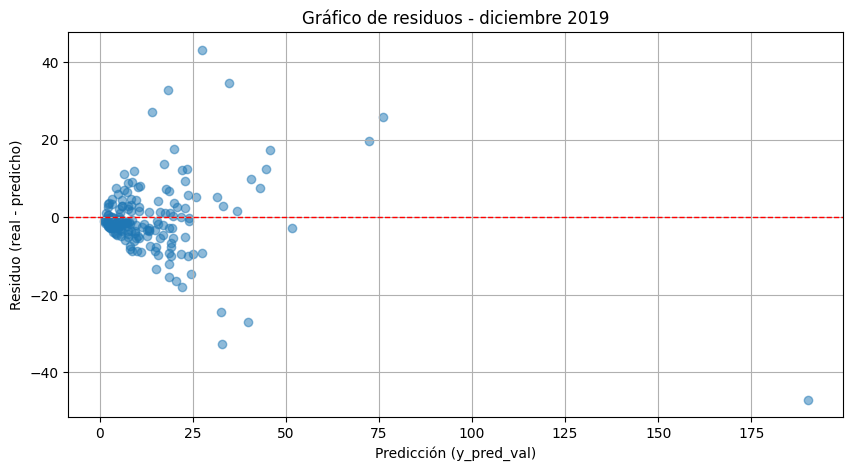

[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
✅ Predicción febrero 2020 guardada en prediccion_feb2020_dstn5_5.csv


C:\Users\waldo\AppData\Local\Temp\ipykernel_4252\420437461.py:140: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feb_df.fillna(0, inplace=True)
C:\Users\waldo\AppData\Local\Temp\ipykernel_4252\420437461.py:146: RuntimeWarning: overflow encountered in expm1
  pred_original = np.expm1(pred_log)


In [5]:
#DESDE ACÁ 6
import pandas as pd
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Cargar datasets
df = pd.read_csv("dstn_5.csv")
df['periodo'] = pd.to_datetime(df['periodo'])
df_clusters = pd.read_csv("dtw_clusters5.csv")  # columnas: product_id, cluster_dtw

# 2. Agrupar por producto y mes
df_prod = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Agregar cluster
df_prod = df_prod.merge(df_clusters, on='product_id', how='left')

# 4. Promedio histórico de febreros (2017–2019)
feb_hist = df_prod[
    (df_prod['periodo'].dt.month == 2) & (df_prod['periodo'].dt.year < 2020)
].groupby('product_id')['tn'].mean().reset_index()
feb_hist.rename(columns={'tn': 'febrero_hist'}, inplace=True)

# 5. Media móvil 12 meses
df_prod = df_prod.sort_values(['product_id', 'periodo'])
df_prod['media_movil_12m'] = (
    df_prod.groupby('product_id')['tn']
    .transform(lambda x: x.rolling(window=12, min_periods=1).mean())
)

# 6. Crear lags
def crear_lags(df, lags=[1, 2, 3]):
    df_lags = df.copy()
    for lag in lags:
        df_lags[f'lag_{lag}'] = df_lags.groupby('product_id')['tn'].shift(lag)
    return df_lags

df_lags = crear_lags(df_prod)
df_lags['mes'] = df_lags['periodo'].dt.month

# 7. Features derivados
df_lags['var_lag1_lag2'] = df_lags['lag_1'] / df_lags['lag_2']
df_lags['delta_lag1_lag2'] = df_lags['lag_1'] - df_lags['lag_2']
df_lags['delta_rel_lag1_lag2'] = df_lags['delta_lag1_lag2'] / df_lags['lag_2']
df_lags['delta_ma12_lag1'] = df_lags['lag_1'] - df_lags['media_movil_12m']
df_lags.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# 8. Preparar entrenamiento
df_train = df_lags.dropna()

features = [
    'lag_1', 'lag_2', 'lag_3', 'mes',
    'media_movil_12m', 'var_lag1_lag2',
    'delta_lag1_lag2', 'delta_rel_lag1_lag2', 'delta_ma12_lag1',
    'cluster_dtw'
]
target = 'tn'

train_data = df_train[df_train['periodo'] < '2019-12-01']
val_data = df_train[df_train['periodo'] == '2019-12-01']

X_train = train_data[features].copy()
y_train = train_data[target]
X_val = val_data[features].copy()
y_val = val_data[target]

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

# 🔄 Log-transform del target
y_train_log = np.log1p(y_train)

# 9. Entrenar modelo
mejores_params = {
    'n_estimators': 261,
    'learning_rate': 0.14224983178543588,
    'max_depth': 10,
    'num_leaves': 23,
    'subsample': 0.8093211391867557,
    'colsample_bytree': 0.9231869885459679,
    'random_state': 42,
    'min_data_in_leaf': 29,
    'reg_alpha': 2.699481657936518,
    'reg_lambda': 2.8632226095063658,
    'linear_tree': True
}
modelo = lgb.LGBMRegressor(**mejores_params)
modelo.fit(X_train, y_train_log)

# 🔄 Predicción log → escala original
y_pred_val_log = modelo.predict(X_val)
y_pred_val = np.expm1(y_pred_val_log)

# ⏱️ Métricas
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)
residuos = y_val - y_pred_val
sesgo = np.mean(residuos)

print(f"📊 MAE en diciembre 2019: {mae:.2f}")
print(f"📈 R² en diciembre 2019: {r2:.4f}")
print(f"📉 Sesgo promedio: {sesgo:.4f}")

# 📉 Gráfico de residuos
plt.figure(figsize=(10, 5))
plt.scatter(y_pred_val, residuos, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicción (y_pred_val)')
plt.ylabel('Residuo (real - predicho)')
plt.title('Gráfico de residuos - diciembre 2019')
plt.grid(True)
plt.savefig("grafico_residuos_diciembre2019.png", dpi=300)
plt.show()

# 11. Predicción febrero 2020
feb_df = pd.DataFrame()
feb_df['product_id'] = df_prod['product_id'].unique()
feb_df['periodo'] = pd.to_datetime('2020-02-01')
feb_df['mes'] = 2

lag1_df = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'media_movil_12m']].rename(columns={'media_movil_12m': 'lag_1'})
lag2 = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'tn']].rename(columns={'tn': 'lag_2'})
lag3 = df_prod[df_prod['periodo'] == '2019-11-01'][['product_id', 'tn']].rename(columns={'tn': 'lag_3'})
media_mov = df_prod[df_prod['periodo'] == '2019-12-01'][['product_id', 'media_movil_12m']]
clusters = df_clusters.copy()

feb_df = feb_df.merge(lag1_df, on='product_id')
feb_df = feb_df.merge(lag2, on='product_id')
feb_df = feb_df.merge(lag3, on='product_id')
feb_df = feb_df.merge(media_mov, on='product_id')
feb_df = feb_df.merge(clusters, on='product_id')

feb_df['var_lag1_lag2'] = feb_df['lag_1'] / feb_df['lag_2']
feb_df['delta_lag1_lag2'] = feb_df['lag_1'] - feb_df['lag_2']
feb_df['delta_rel_lag1_lag2'] = feb_df['delta_lag1_lag2'] / feb_df['lag_2']
feb_df['delta_ma12_lag1'] = feb_df['lag_1'] - feb_df['media_movil_12m']
feb_df = feb_df.merge(feb_hist, on='product_id', how='left')
feb_df.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
feb_df.fillna(0, inplace=True)

X_feb = feb_df[features].astype('float32')

# 🔄 Predicción log → original con control de inf/NaN
pred_log = modelo.predict(X_feb)
pred_original = np.expm1(pred_log)
pred_original = np.where(np.isfinite(pred_original), pred_original, 0)

feb_df['tn_predicho_modelo'] = pred_original

# 🔄 Control en histórico también (sin tocar valores válidos)
feb_df['febrero_hist'] = feb_df['febrero_hist'].replace([np.inf, -np.inf], np.nan).fillna(0)

# 🔄 Combinación con histórico: 60% modelo + 30% promedio febrero 2017–2019
feb_df['tn_predicho_ajustada'] = (
    0.5 * feb_df['tn_predicho_modelo'] + 0.5 * feb_df['febrero_hist']
)



# 13. Exportar
resultado = feb_df[['product_id', 'tn_predicho_ajustada']].rename(columns={'tn_predicho_ajustada': 'tn_predicho'})
resultado.to_csv("prediccion_feb2020_dstn5_5.csv", index=False)
print("✅ Predicción febrero 2020 guardada en prediccion_feb2020_dstn5_5.csv")


In [2]:
#DESDE ACÁ 7
import pandas as pd

# 1. Cargar predicción de febrero 2020
df_pred = pd.read_csv("prediccion_feb2020_dstn5_4.csv")  # archivo generado por el modelo
df_pred['periodo'] = pd.to_datetime("2020-02-01")
df_pred.rename(columns={'tn_predicho': 'tn'}, inplace=True)

# 2. Cargar dataset original
df_real = pd.read_csv("dstn_5.csv")
df_real["periodo"] = pd.to_datetime(df_real["periodo"])

# 3. Agrupar por período y sumar toneladas reales
tn_reales = df_real.groupby(["periodo"])["tn"].sum().reset_index()

# 4. Sumar toneladas predichas para febrero 2020
tn_feb2020 = df_pred.groupby("periodo")["tn"].sum().reset_index()

# 5. Unir y ordenar
comparacion = pd.concat([tn_reales, tn_feb2020], ignore_index=True)
comparacion = comparacion.sort_values("periodo").reset_index(drop=True)

# 6. Mostrar resultado
print("📊 Total de toneladas por período (incluye predicción febrero 2020):")
print(comparacion.tail(36))  # los últimos 12 períodos


📊 Total de toneladas por período (incluye predicción febrero 2020):
      periodo          tn
1  2017-02-01  2623.92801
2  2017-03-01  3785.94226
3  2017-04-01  3087.45217
4  2017-05-01  3816.74532
5  2017-06-01  3414.56684
6  2017-07-01  2752.89006
7  2017-08-01  3311.01980
8  2017-09-01  3872.69107
9  2017-10-01  4152.03612
10 2017-11-01  3680.59720
11 2017-12-01  3212.72167
12 2018-01-01  2385.91128
13 2018-02-01  2832.75806
14 2018-03-01  4122.74505
15 2018-04-01  3057.31482
16 2018-05-01  3336.06850
17 2018-06-01  3120.92168
18 2018-07-01  2893.13824
19 2018-08-01  3375.19812
20 2018-09-01  2876.73836
21 2018-10-01  3385.59828
22 2018-11-01  2830.99486
23 2018-12-01  2479.69205
24 2019-01-01  2822.57528
25 2019-02-01  2708.16223
26 2019-03-01  3302.82738
27 2019-04-01  3117.58078
28 2019-05-01  3171.45066
29 2019-06-01  2661.68591
30 2019-07-01  3065.45557
31 2019-08-01  2419.03255
32 2019-09-01  3085.64890
33 2019-10-01  3207.73964
34 2019-11-01  3215.25430
35 2019-12-01  2381.40

📊 Error por decil histórico:
   decil_hist  tn_predicho  febrero_hist  error_abs  error_relativo
0           1     3.155071      1.584565   1.931515   428312.853237
1           2     3.733000      3.327505   1.659503        0.540517
2           3     5.032309      5.079970   2.037536        0.411672
3           4     8.066509      7.343055   2.515362        0.329986
4           5     8.468884      9.427448   1.935496        0.210436
5           6    11.403076     12.468018   2.796720        0.222727
6           7    14.228773     15.385453   2.962197        0.192963
7           8    19.497923     18.548929   5.182064        0.290950
8           9    21.834030     27.606204   6.130772        0.210747
9          10    45.239351     59.323917  14.244616        0.250274

📊 Error por cluster DTW:
   cluster_dtw  tn_predicho  febrero_hist  error_abs  error_relativo
0            0    13.882355     14.848753   2.308032        0.235978
1            1    13.859621     17.539977   4.574493       

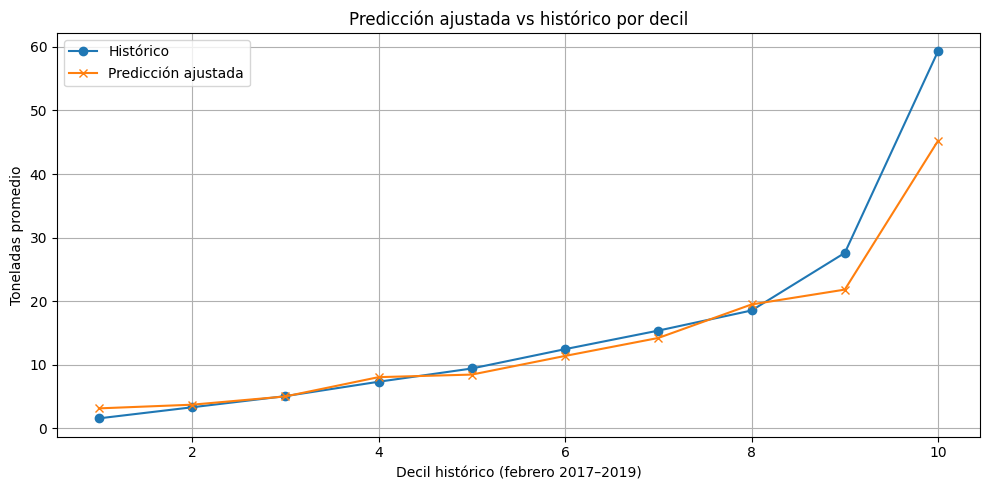

In [3]:
#DESDE ACÁ 8

# 1. Deciles históricos (1 = bajo, 10 = alto)
feb_df['decil_hist'] = pd.qcut(feb_df['febrero_hist'], q=10, labels=False, duplicates='drop') + 1

# 2. Métricas por decil
decil_stats = feb_df.groupby('decil_hist').agg(
    tn_predicho=('tn_predicho_ajustada', 'mean'),
    febrero_hist=('febrero_hist', 'mean'),
    error_abs=('tn_predicho_ajustada', lambda x: np.mean(np.abs(x - feb_df.loc[x.index, 'febrero_hist']))),
    error_relativo=('tn_predicho_ajustada', lambda x: np.mean(np.abs(x - feb_df.loc[x.index, 'febrero_hist']) / (feb_df.loc[x.index, 'febrero_hist'] + 1e-6)))
).reset_index()

print("📊 Error por decil histórico:")
print(decil_stats)

# 3. Métricas por cluster DTW
cluster_stats = feb_df.groupby('cluster_dtw').agg(
    tn_predicho=('tn_predicho_ajustada', 'mean'),
    febrero_hist=('febrero_hist', 'mean'),
    error_abs=('tn_predicho_ajustada', lambda x: np.mean(np.abs(x - feb_df.loc[x.index, 'febrero_hist']))),
    error_relativo=('tn_predicho_ajustada', lambda x: np.mean(np.abs(x - feb_df.loc[x.index, 'febrero_hist']) / (feb_df.loc[x.index, 'febrero_hist'] + 1e-6)))
).reset_index()

print("\n📊 Error por cluster DTW:")
print(cluster_stats)

# 4. Gráfico comparativo por decil
plt.figure(figsize=(10,5))
plt.plot(decil_stats['decil_hist'], decil_stats['febrero_hist'], label='Histórico', marker='o')
plt.plot(decil_stats['decil_hist'], decil_stats['tn_predicho'], label='Predicción ajustada', marker='x')
plt.xlabel('Decil histórico (febrero 2017–2019)')
plt.ylabel('Toneladas promedio')
plt.title('Predicción ajustada vs histórico por decil')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("comparacion_por_decil_ajustada.png", dpi=300)
plt.show()



📋 Comparativo global:
🔍 Modelo puro: MAE=6.90, R²=0.5075, Sesgo=3.24
🔍 Predicción ajustada: MAE=4.14, R²=0.8227, Sesgo=1.94


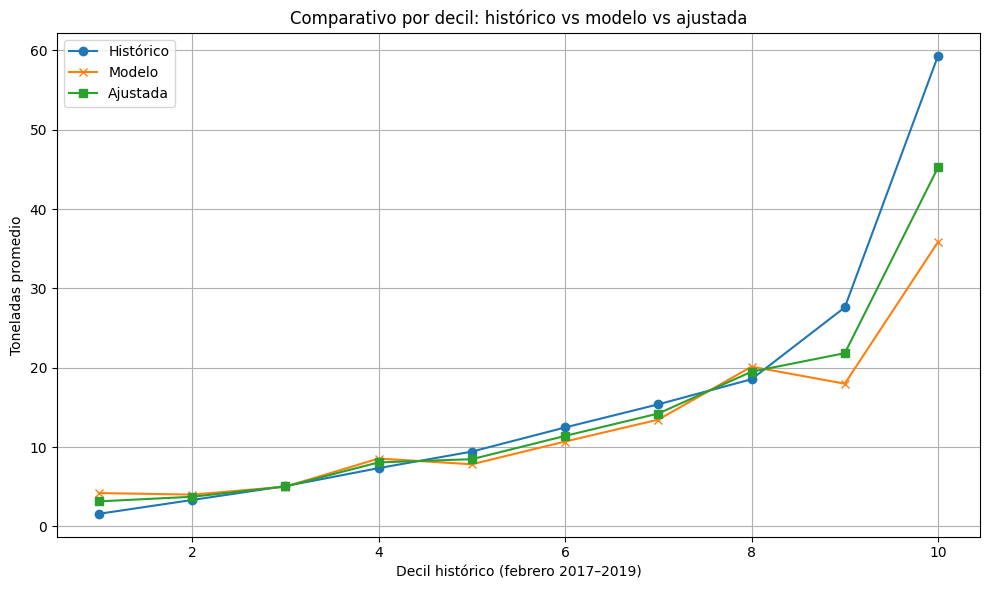

In [4]:
#DESDE ACÁ 9

# ===============================
# COMPARATIVO MODELO VS AJUSTADA
# ===============================

# 1. Métricas generales
def resumen_error(real, pred, nombre):
    mae = mean_absolute_error(real, pred)
    r2 = r2_score(real, pred)
    sesgo = np.mean(real - pred)
    print(f"🔍 {nombre}: MAE={mae:.2f}, R²={r2:.4f}, Sesgo={sesgo:.2f}")

print("\n📋 Comparativo global:")
resumen_error(feb_df['febrero_hist'], feb_df['tn_predicho_modelo'], "Modelo puro")
resumen_error(feb_df['febrero_hist'], feb_df['tn_predicho_ajustada'], "Predicción ajustada")

# 2. Comparación gráfica por decil
feb_df['decil_hist'] = pd.qcut(feb_df['febrero_hist'], q=10, labels=False, duplicates='drop') + 1

comparativo = feb_df.groupby('decil_hist').agg(
    febrero_hist=('febrero_hist', 'mean'),
    modelo=('tn_predicho_modelo', 'mean'),
    ajustada=('tn_predicho_ajustada', 'mean')
).reset_index()

# 3. Plot comparativo
plt.figure(figsize=(10, 6))
plt.plot(comparativo['decil_hist'], comparativo['febrero_hist'], label='Histórico', marker='o')
plt.plot(comparativo['decil_hist'], comparativo['modelo'], label='Modelo', marker='x')
plt.plot(comparativo['decil_hist'], comparativo['ajustada'], label='Ajustada', marker='s')
plt.xlabel('Decil histórico (febrero 2017–2019)')
plt.ylabel('Toneladas promedio')
plt.title('Comparativo por decil: histórico vs modelo vs ajustada')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("comparativo_modelo_vs_ajustada_por_decil.png", dpi=300)
plt.show()
